# Regression

In statistical modeling, regression analysis is a set of statistical processes for estimating the relationships between a dependent variable (often called the 'outcome variable') and one or more independent variables (often called 'predictors', 'covariates', or 'features'). The most common form of regression analysis is linear regression, in which a researcher finds the line (or a more complex linear combination) that most closely fits the data according to a specific mathematical criterion. That means, this model doesn't classify the input variable by class, but it predicts a real number.

In this notebook, we generate a dataset of points following a specific distribution. Then we generate and train linear and  hidden neural networks. Finally, we compare the result of both kinds of models in the regression process.

## Imports and configuration

In [18]:
import random
import torch
from torch import nn, optim
import math
from IPython import display

In [19]:
from res.plot_lib import plot_data, plot_model, set_default
from matplotlib import pyplot as plt

In [20]:
set_default()

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device : {device}")

Device : cuda:0


## Generate Dataset

Define the generation parameters

In [5]:
seed = 1
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
D = 1     # dimensions
C = 1     # num_classes
H = 100   # num_hidden_units

Generate datapoints following a specific distribution

In [30]:
X = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1).to(device) # 100 equidistance points from -1 to 1 
y = X.pow(3) + 0.3 * torch.rand(X.size()).to(device) 

In [31]:
print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (100, 1)
y: (100, 1)


Plot the generated points

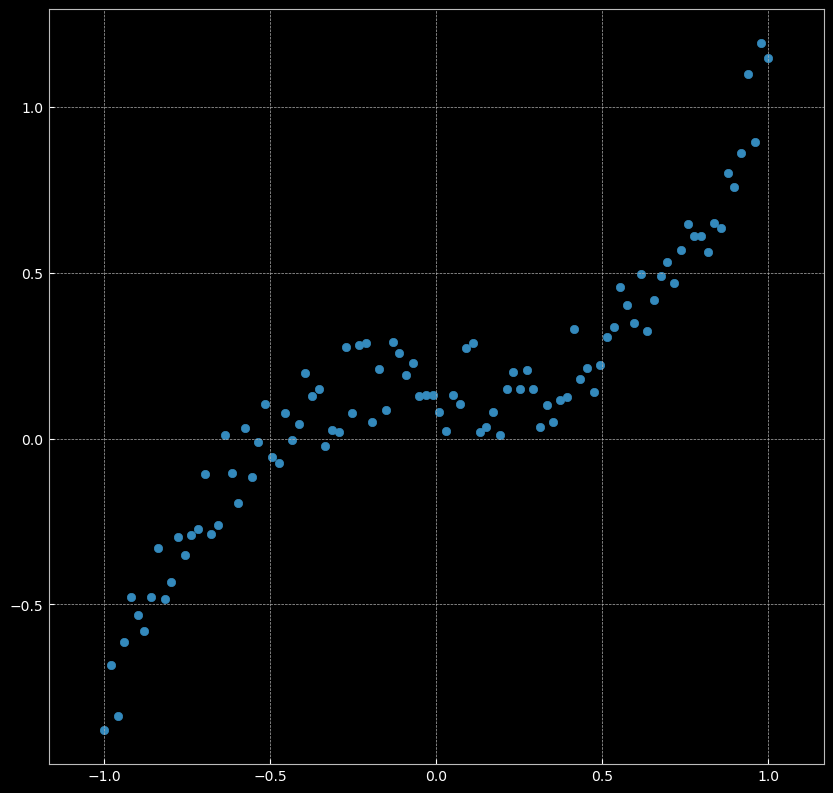

In [32]:
plt.scatter(X.cpu().numpy(), y.cpu().numpy())
plt.axis('equal');

## Train model
We train a network to predict the class of a point in basis the input examples (x,y)

### Linear model

This model only is training using linear transformations (rotation, reflexion and shrink) for the input dataset.

In [53]:
learning_rate = 1e-3
lambda_l2 = 1e-5

Define the model

In [54]:
# nn package to create our linear model
# each Linear module has a weight and bias
model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)
model.to(device) # Convert to CUDA

# nn package also has different loss functions.
# we use MSE loss for our regression task
criterion = torch.nn.MSELoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

Train the linear model

In [55]:
# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss (MSE)
    loss = criterion(y_pred, y)    
    
    print("[EPOCH]: %i, [LOSS or MSE]: %.6f" % (t, loss.item())) 
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS or MSE]: 0.031053


Display

In [11]:
# Plot trained model
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=1, bias=True)
)


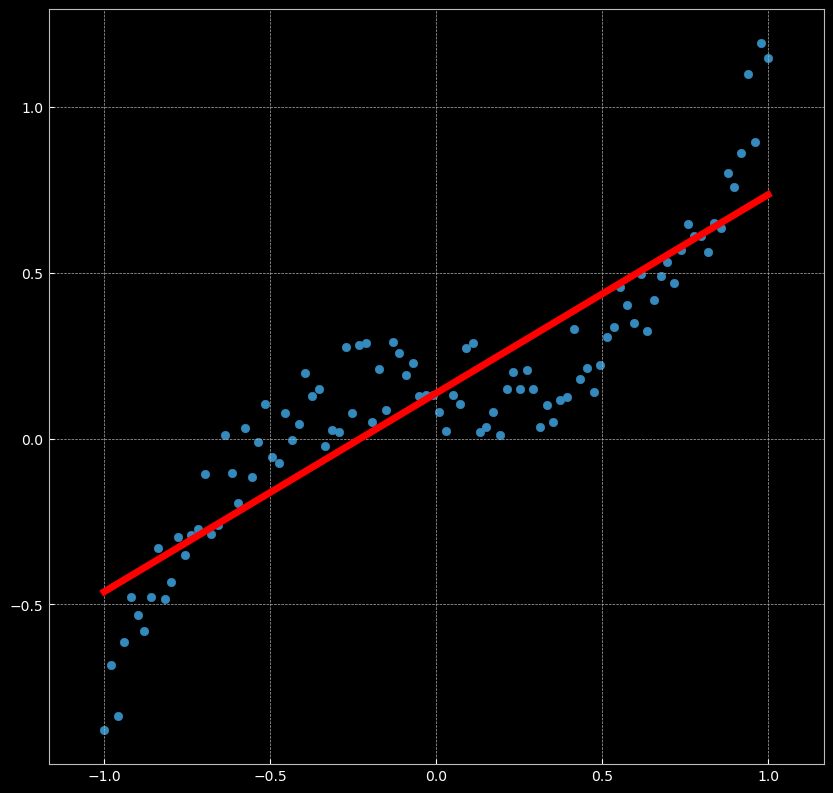

In [56]:
plt.scatter(X.data.cpu().numpy(), y.data.cpu().numpy())
plt.plot(X.data.cpu().numpy(), y_pred.data.cpu().numpy(), 'r-', lw=5)
plt.axis('equal');

A linear model only can generate a linear prediction

### Two-layered network

This model includes a hidden layer with a non-linear function.

In particular, we generate `n_networks` different networks (or models). Some of them with a `ReLU` and other with a `Tanh` functions as non-linear function

In [59]:
learning_rate = 1e-3
lambda_l2 = 1e-5

Define and train networks

In [63]:
# Number of networks
n_networks = 10
models = list()
y_pretrain = list()

# nn package also has different loss functions.
# we use MSE for a regression task
criterion = torch.nn.MSELoss()

# We generate n diff networks
for mod in range(n_networks):
    
    # nn package to create our linear model
    # each Linear module has a weight and bias
    model = nn.Sequential(
        nn.Linear(D, H),
        nn.ReLU() if mod < n_networks // 2 else nn.Tanh(), # We change the non-linear functions
        nn.Linear(H, C)
    )
    model.to(device)
    
    # Append models
    models.append(model)

    # we use the optim package to apply
    # ADAM for our parameter updates
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

    # e = 1.  # plotting purpose

    # Training each generated network
    for t in range(1000):

        # Feed forward to get the logits
        y_pred = model(X)
        
        # Append pre-train output
        if t == 0:
            y_pretrain.append(y_pred.detach())

        # Compute the loss and accuracy
        loss = criterion(y_pred, y)
        print(f"[MODEL]: {mod + 1}, [EPOCH]: {t}, [LOSS]: {loss.item():.6f}")
        display.clear_output(wait=True)

        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()

        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()

        # Update params
        optimizer.step()

[MODEL]: 10, [EPOCH]: 999, [LOSS]: 0.007334


Display

In [64]:
print(f"Number of generated and trained models : {len(models)}")

Number of generated and trained models : 10


In [65]:
print(f"First model network:")
print(models[0])

print()
print(f"Last model network:")
print(models[-1])

First model network:
Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)

Last model network:
Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Tanh()
  (2): Linear(in_features=100, out_features=1, bias=True)
)


#### Predictions: Before Training

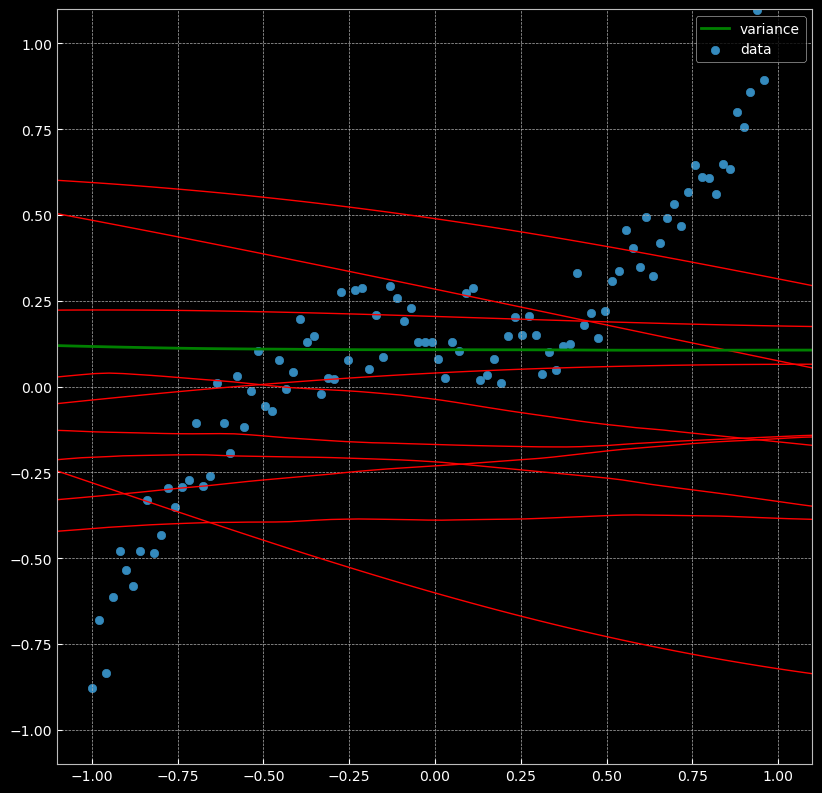

In [66]:
for y_pretrain_idx in y_pretrain:
    # New X that ranges from -5 to 5 instead of -1 to 1
    X_new = torch.unsqueeze(torch.linspace(-2, 2, 100), dim=1)
        
    plt.plot(X_new.numpy(), y_pretrain_idx.cpu().numpy(), 'r-', lw=1)

plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label='data')
plt.axis('square')
plt.axis((-1.1, 1.1, -1.1, 1.1));
y_combo = torch.stack(y_pretrain)
plt.plot(X_new.numpy(), y_combo.var(dim=0).cpu().numpy(), 'g', label='variance');
plt.legend()

This plot shows the predictions of the `n_networks`models (red lines) just before we created them (without any training). Logically, the predictions are random.

#### Predictions: After Training

We are going to plot the predictions in 2 different graphs to compare the non-linear functions. One graph with the predictions of the models with `ReLU` as non-linear function. And the other with models with `Tanh` as non-linear functions.

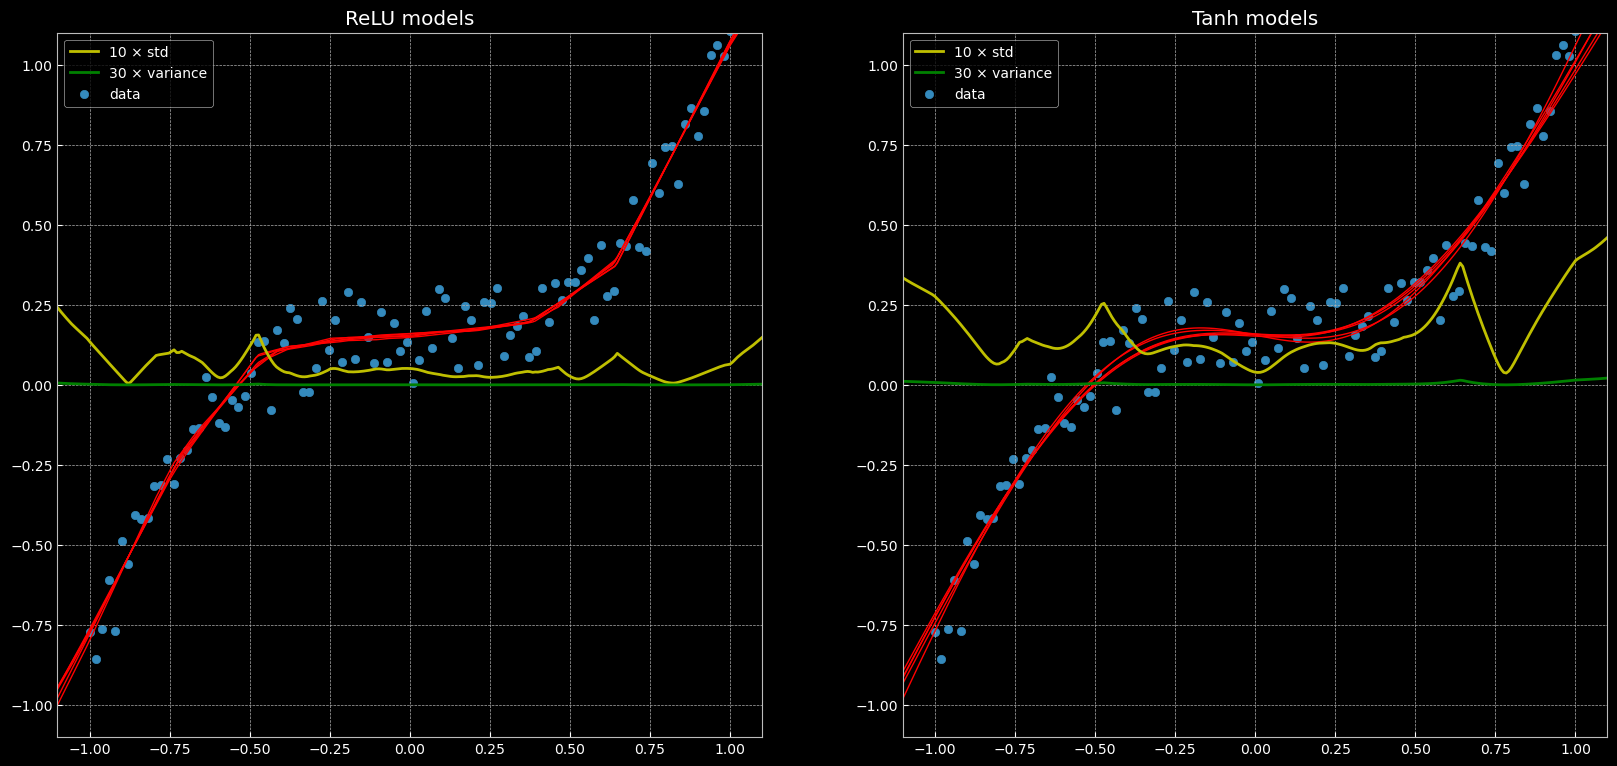

In [17]:
y_pred = list()
relu_models = models[:n_networks // 2]
tanh_models = models[n_networks // 2:]
plt.figure(figsize=(20, 10))

def dense_prediction(models, non_linearity, zoom):
    plt.subplot(1, 2, 1 if non_linearity == 'ReLU' else 2)
    for model in models:
        # New X that ranges from -5 to 5 instead of -1 to 1
        X_new = torch.unsqueeze(torch.linspace(-4, 4, 1001), dim=1).to(device)

        # Getting predictions from input
        with torch.no_grad():
            y_pred.append(model(X_new))

        plt.plot(X_new.cpu().numpy(), y_pred[-1].cpu().numpy(), 'r-', lw=1)
    plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label='data')
    plt.axis('square')
    plt.axis(torch.tensor((-1.1, 1.1, -1.1, 1.1)) * zoom);
    y_combo = torch.stack(y_pred)
    plt.plot(X_new.cpu().numpy(), 10 * y_combo.var(dim=0).cpu().sqrt().numpy(), 'y', label='10 × std')
    plt.plot(X_new.cpu().numpy(), 10 * y_combo.var(dim=0).cpu().numpy(), 'g', label='30 × variance')
    plt.legend()
    plt.title(non_linearity + ' models')

z = 1  # try 1 or 4
dense_prediction(relu_models, 'ReLU', zoom=z)
dense_prediction(tanh_models, 'Tanh', zoom=z)

We can see, `ReLu` models make an aproximation to the prediction as a composition of linear steps. On the other hand, `Tanh` models prediction is more smooth. It can be explained by the nature of each of this `non-linear` functions.

 - What happens when zooming out?

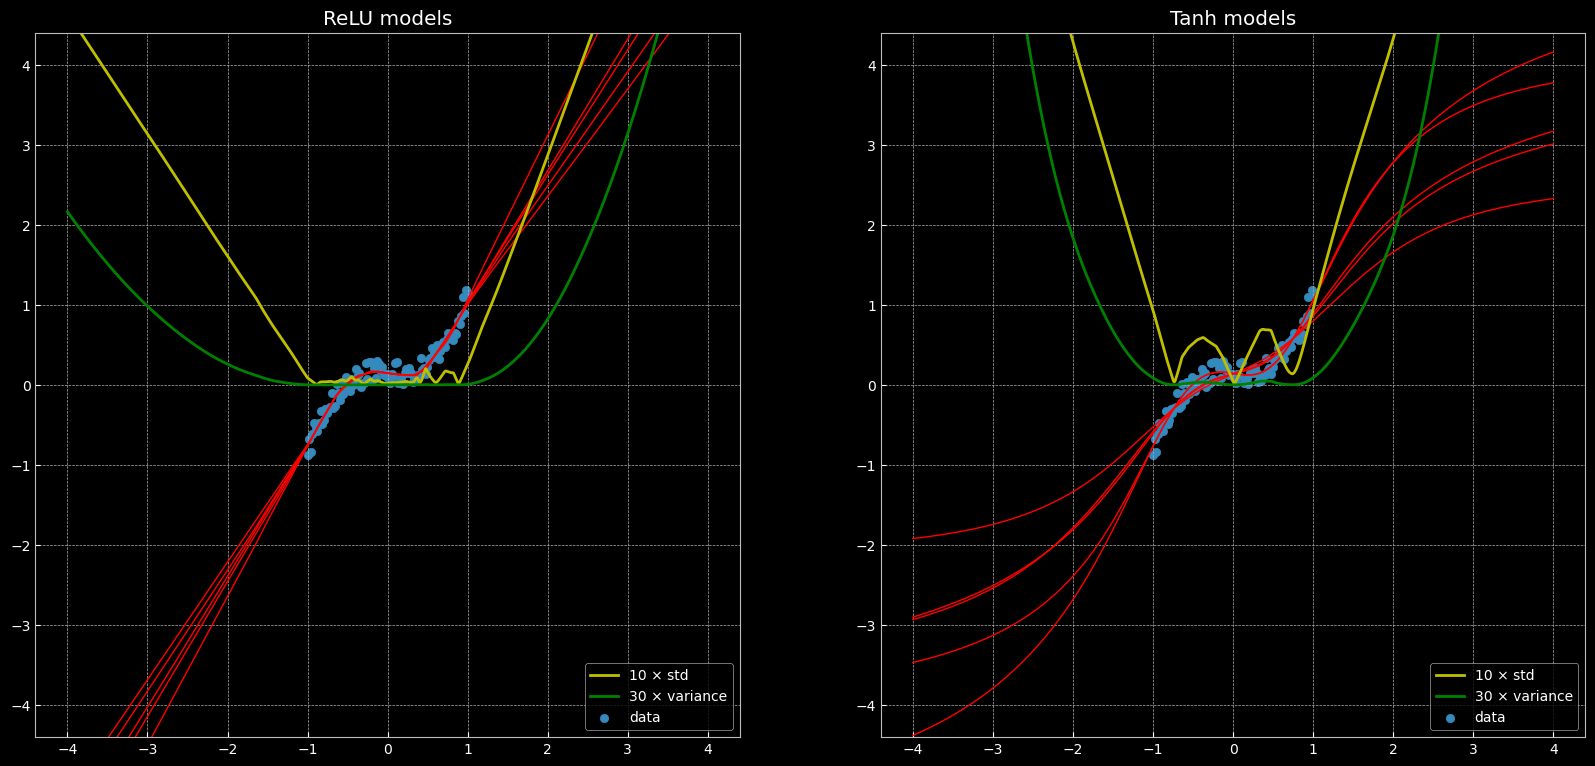

In [72]:
y_pred = list()
plt.figure(figsize=(20, 10))
    
z = 4
dense_prediction(relu_models, 'ReLU', zoom=z)
dense_prediction(tanh_models, 'Tanh', zoom=z)

The predictions in far to the distribution points are more disperse because there isn't any information about how it has to perform in this space. In this case, `ReLU` seems more deterministic because use linear distributions.

To conclude: we can see that different initializated models (with the same network structure but random weights) generate similar (but not exactly the same) predictions with the same training process. 